## <font color = Green> Retrieval Augmented Generation on Email Dataset

We are going to follow the below RAG Pipeline

1. **Embedding Layer**
2. **Search & Ranking Layer**
3. **Generation Layer**






## 1. <font color = red> Install and Import the Required Libraries

In [15]:
# Install all the required libraries
!pip install -U -q tiktoken openai chromadb sentence-transformers

In [16]:
# Import all the required Libraries
from pathlib import Path
import pandas as pd
import json
import tiktoken
import openai
import chromadb

In [17]:
# If we are working on google colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Embedding Layer


#### <font color = red> 2.1 Process the threads dataset



**Step 1** : Read the email threads

**Step 2** : Join all the from and to values to find out all the participants in the thread

**Step 3** : Find the subject of the thread

**Step 4** : Have a single for one thread

**Step 5**: Include Body of all emails in thread

In [18]:
dataset_path_emails = './email_thread_details.csv'
dataset_path_summaries = './email_thread_summaries.csv'
chroma_data_path = './ChromaDB_Data'
openai.api_key = 'API_KEY'

In [19]:
df_email = pd.read_csv(dataset_path_emails)
df_email

,thread_id,subject,timestamp,from,to,body
0,1,FW: Master Termination Log,2002-01-29 11:23:42,"Gossett, Jeffrey C. JGOSSET","['Giron', 'Darron C. Dgiron', 'Love', 'Phillip...",\n\n -----Original Message-----\nFrom: =09Ther...
1,1,FW: Master Termination Log,2002-01-31 12:50:00,"Theriot, Kim S. KTHERIO","['Murphy', 'Melissa Mmurphy', 'Gossett', 'Jeff...",\n\n -----Original Message-----\nFrom: =09Panu...
2,1,FW: Master Termination Log,2002-02-05 15:03:35,"Theriot, Kim S. KTHERIO","['Murphy', 'Melissa Mmurphy', 'Anderson', 'Dia...",Note to Stephanie Panus....\n\nStephanie...ple...
3,1,FW: Master Termination Log,2002-02-05 15:06:25,"Theriot, Kim S. KTHERIO","['Hall', 'D. Todd Thall', 'Sweeney', 'Kevin Ks...",\n\n -----Original Message-----\nFrom: =09Panu...
4,1,FW: Master Termination Log,2002-05-28 07:20:35,"Kelly, Katherine L. KKELLY","['Germany', 'Chris Cgerman']",\n\n -----Original Message-----\nFrom: =09McMi...
...,...,...,...,...,...,...
21679,4166,vacation,2000-10-04 11:32:00,Sara Shackleton,"['Gary Hickerson', 'Sheila Glover', 'Laurel Ad...",I will be on vacation from October 6- 13. Als...
21680,4167,web file,2001-03-18 22:57:00,Matt Smith,['Amanda Huble'],"Amanda,\n\nCan you put this file in the approp..."
21681,4167,web file,2001-03-19 04:42:00,Matt Smith,['Amanda Huble'],"Amanda,\n\nPlease move the file i sent you fro..."
21682,4167,web file,2001-03-19 09:57:00,Matt Smith,['Amanda Huble <Amanda Huble/NA/Enron@Enron'],"Amanda,\n\nCan you put this file in the approp..."


In [20]:
import ast

def extract_participants(row):
    to_list = ast.literal_eval(row['to'])
    participants = set(to_list + [row['from']])
    return participants

# Apply the function to each row to get a list of participants
df_email['participants'] = df_email.apply(extract_participants, axis=1)

# Group by thread_id and aggregate the required columns
result = df_email.groupby('thread_id').agg({
    'subject': 'first',
    'participants': lambda x: set().union(*x),
    'body': lambda x: ' '.join(x)
}).reset_index()

# Convert the set of participants to a sorted list for readability
result['participants'] = result['participants'].apply(lambda x: sorted(x))

# Display the result
print(result)

      thread_id                                            subject  \
0             1                         FW: Master Termination Log   
1             2                                 Credit Group Lunch   
2             3                                        New Address   
3             4                                           EOL Data   
4             5                         RE: long form confirm/MDEA   
...         ...                                                ...   
4162       4163  ltr to Kay Mann: Site specific references in G...   
4163       4164                                       presentation   
4164       4165                                       this weekend   
4165       4166                                           vacation   
4166       4167                                           web file   

                                           participants  \
0     [Anderson, Aucoin, Baxter, Bryce Bbaxter, Chri...   
1     [Carol St Clair, Kaye Ellis, Mark T

#### <font color = red> 2.2 Join the processed rows from above with the summaries dataset


In [80]:
df_summary = pd.read_csv(dataset_path_summaries)
df_summary


0     The email thread discusses the Master Terminat...
1     A lunch meeting has been scheduled for May 5th...
2     Ben is updating a friend on his progress with ...
3     The recipient of the email thread initially ex...
4     The email thread discusses the long form confi...
                            ...                        
95    Leonardo Pacheco informs David Portz that he w...
96    There is a billing error for Smurfit due to ch...
97    The sender apologizes for missing a call and e...
98    Bryan asks Tom for guidance on starting the ro...
99    Insight Capital Partners hosts quarterly dinne...
Name: summary, Length: 100, dtype: object

In [22]:
df_summary['Text_Length'] = df_summary['summary'].apply(lambda x: len(x.split(' ')))
df_summary['Text_Length'].max()

182

In [23]:
merged_df = pd.merge(result, df_summary, on='thread_id')

In [158]:
# Retain only the rows with a text length of at least 10
merged_df = merged_df.loc[merged_df['Text_Length'] >= 10]
merged_df

0                                                                                                                                                                                                                                                     The email thread discusses the Master Termination Log and the need to investigate a CNG LDC (Hope Gas) termination and a $66 million settlement offer. Stephanie Panus sends out the Daily List and Master Termination Log for various dates. Kim Theriot requests her name and Melissa Murphy's name to be removed from the distribution list and adds several names to it. The thread also includes updates on terminations and valid terminations for various companies.
1                                                                                                                                                                                                                                                                               A lunch meeting has be

This concludes the pre processing aspect

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [25]:
import chromadb

In [26]:
# Call PersistentClient()
chroma_client = chromadb.PersistentClient()

In [27]:
# Set up the embedding function using the OpenAI embedding model
model= "text-embedding-ada-002"

In [28]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
email_collection = chroma_client.get_or_create_collection(name='RAG_on_email')

In [29]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
from openai import OpenAI
client = OpenAI(api_key=openai.api_key)

documents_list = merged_df["summary"].tolist()
ids_list = merged_df["thread_id"].tolist()

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

merged_df['ada_embedding'] = merged_df.summary.apply(lambda x: get_embedding(x, model="text-embedding-ada-002"))


In [30]:
documents_list = merged_df["summary"].tolist()
ids_list = merged_df["thread_id"].tolist()
embeddings_list = merged_df["ada_embedding"].tolist()
bodies_list = merged_df["body"].tolist()
participants_list = merged_df["participants"].tolist()


for i, email in enumerate(documents_list):
    email_collection.add(
        ids=[str(ids_list[i])],  # Add IDs as strings
        documents=[email],  # Single string in a list
        embeddings=[embeddings_list[i]],  # Ensure embeddings are lists
        metadatas=[{ "body": bodies_list[i], "participants": str(participants_list[i])}]  # Metadata should be in list format
    )

In [31]:
cache_collection = chroma_client.get_or_create_collection(name='Email_Cache')

In [32]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'metadatas', 'documents']}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [159]:
# Read the user query
query = input()

What is the impact of federal price limits on power companies


In [160]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results
get_embedding(query)
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [161]:
cache_results

{'ids': [['what is the service P&L for demand charges']],
 'distances': [[1.3818418038971152]],
 'metadatas': [[{'distances0': '0.24148112535476685',
    'distances1': '0.30288636684417725',
    'distances2': '0.38486993312835693',
    'distances3': '0.398654580116272',
    'distances4': '0.40745097398757935',
    'distances5': '0.4146004915237427',
    'distances6': '0.4208914637565613',
    'distances7': '0.4217303693294525',
    'documents0': "The email thread discusses the use of the service P&L for demand charges and the discomfort of some individuals in using it. David Oliver mentions that the main reason for not using the service P&L is the discomfort of Chris, Dan, and Judy. He also mentions that they haven't moved because Chris hasn't had time to transfer the data from spreadsheets. Colleen Sullivan suggests allocating demand charges for certain pipelines to the Market East P&L. Crystal Hyde mentions that she is unable to complete the Transport P&L due to reconstruction on the

In [162]:
query_embeddings_list = get_embedding(query)

results = email_collection.query(
query_embeddings=query_embeddings_list,
n_results=10
)
len(results)

8

In [163]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
bodies = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      query_embeddings_list = get_embedding(query)
      results = email_collection.query(
      query_embeddings=query_embeddings_list,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      print(results)
      for key, val in results.items():
        if val is None:
          continue
        for i in range(len(results)):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")
      result_dict = { 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0],  "Metadatas":results["metadatas"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              bodies.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas' : bodies
      })


{'ids': [['2591', '300', '1464', '163', '309', '14', '411', '777', '3585', '444']], 'distances': [[0.2398618757724762, 0.29624488949775696, 0.29866325855255127, 0.3029829263687134, 0.3067553639411926, 0.30794912576675415, 0.3107225000858307, 0.3121803104877472, 0.3154807388782501, 0.3158174753189087]], 'metadatas': [[{'body': 'Great dialog on everything that\'s wrong with price controls. \n\n -----Original Message-----\nFrom:  "Onukogu, Ernest" <Ernest.Onukogu@dowjones.com>@ENRON \n[mailto:IMCEANOTES-+22Onukogu+2C+20Ernest+22+20+3CErnest+2EOnukogu+40dowjones+\n2Ecom+3E+40ENRON@ENRON.com] \nSent: Friday, July 06, 2001 1:11 PM\nTo: undisclosed-recipients:;@ENRON\nSubject: POWER POINTS:Nevada Suffers FERC Unintended Consequences --\n\n> POWER POINTS:Nevada Suffers FERC Unintended Consequences\n>\n>    By Mark Golden\n>    A Dow Jones Newswires Column\n>\n>   NEW YORK (Dow Jones)--Those who have opposed wholesale electricity price\n> controls have been labeled as extreme free-market ideolo

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

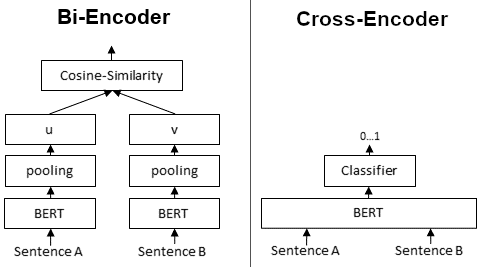

<br>

In [164]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [165]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
results_df

,Documents,Distances,IDs,Metadatas
0,The Federal Energy Regulatory Commission's (FE...,0.239862,2591,{'body': 'Great dialog on everything that's wr...
1,Enron has drafted a potential filing for Judge...,0.296245,300,{'body': 'My suggestions are attached. Take th...
2,The email thread discusses the California elec...,0.298663,1464,{'body': 'Thanks. 415.782.7854. Better or wo...
3,"Government-owned utilities, including the Los ...",0.302983,163,{'body': 'Energy Cost Study Critical of Public...
4,The California Public Utilities Commission (PU...,0.306755,309,{'body': 'Please forward this to anyone I have...
5,The California Independent System Operator (Ca...,0.307949,14,{'body': 'The trading flooor needs to formulat...
6,The email thread discusses a presentation made...,0.310723,411,"{'body': 'Last Thursday, I made the first atta..."
7,The email thread discusses the power crisis in...,0.312180,777,"{'body': 'California=01,s power crisis has gen..."
8,The email thread discusses the House and Senat...,0.315481,3585,"{'body': 'Ray, Commissioner Hebert may have b..."
9,Southern California Edison has filed a motion ...,0.315817,444,{'body': 'Please get copies to me asap of the ...


In [166]:
type(results_df['Metadatas'])

pandas.core.series.Series

In [167]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs
results_df['body'] = results_df['Metadatas'].apply(lambda x: x['body'] if isinstance(x, dict) and 'body' in x else ast.literal_eval(x)['body'])
results_df['participants'] = results_df['Metadatas'].apply(lambda x: x['participants'] if isinstance(x, dict) and 'participants' in x else ast.literal_eval(x)['participants'])
cross_inputs = [[query, response] for response in results_df['body']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [168]:
cross_rerank_scores

array([ -5.1283073 ,  -0.83517826, -11.023021  ,  -4.9723616 ,
        -5.1822734 , -11.332001  ,  -8.493763  ,  -7.3997865 ,
       -10.674316  ,  -9.460273  ], dtype=float32)

In [169]:
# Store the rerank_scores in results_df
results_df['Reranked_scores'] = cross_rerank_scores

In [170]:
results_df

,Documents,Distances,IDs,Metadatas,body,participants,Reranked_scores
0,The Federal Energy Regulatory Commission's (FE...,0.239862,2591,{'body': 'Great dialog on everything that's wr...,Great dialog on everything that's wrong with p...,"['""Ann Cohn (E-mail)"" <cohnap@sce.com', '""Barb...",-5.128307
1,Enron has drafted a potential filing for Judge...,0.296245,300,{'body': 'My suggestions are attached. Take th...,My suggestions are attached.\nTake the gloves ...,"['James D Steffes', 'James D Steffes <James D ...",-0.835178
2,The email thread discusses the California elec...,0.298663,1464,{'body': 'Thanks. 415.782.7854. Better or wo...,Thanks. 415.782.7854. Better or worse than o...,"['Dorothy Rothrock <drothrock@cmta.net', 'Jeff...",-11.023021
3,"Government-owned utilities, including the Los ...",0.302983,163,{'body': 'Energy Cost Study Critical of Public...,Energy Cost Study Critical of Public Agencies ...,"['Alan Comnes', 'Angela Schwarz', 'Beverly Ade...",-4.972362
4,The California Public Utilities Commission (PU...,0.306755,309,{'body': 'Please forward this to anyone I have...,Please forward this to anyone I have forgotten...,"['Alan Comnes', 'Brian Dafferner', 'Chris H Fo...",-5.182273
5,The California Independent System Operator (Ca...,0.307949,14,{'body': 'The trading flooor needs to formulat...,The trading flooor needs to formulate a positi...,"['James D Steffes', 'Jeff Dasovich', 'Karen De...",-11.332001
6,The email thread discusses a presentation made...,0.310723,411,"{'body': 'Last Thursday, I made the first atta...","Last Thursday, I made the first attached prese...","['Chris H Foster', 'Christopher F Calger', 'Da...",-8.493763
7,The email thread discusses the power crisis in...,0.312180,777,"{'body': 'California=01,s power crisis has gen...","California=01,s power crisis has generated hea...","['All Enron Worldwide', 'Gerald Nemec', 'Heath...",-7.399786
8,The email thread discusses the House and Senat...,0.315481,3585,"{'body': 'Ray, Commissioner Hebert may have b...","Ray,\n Commissioner Hebert may have been more ...","['Ray Alvarez', 'Steve Walton', 'Steven J Kean']",-10.674316
9,Southern California Edison has filed a motion ...,0.315817,444,{'body': 'Please get copies to me asap of the ...,Please get copies to me asap of the Edison mot...,"['Bruno Gaillard', 'Drew Fossum', 'Jeff Dasovi...",-9.460273


In [171]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')

top_3_semantic = top_3_semantic[["Documents", "IDs", "body", "participants"]][:3]
top_3_semantic = top_3_semantic.rename(columns={
    'Documents': 'summary',
    'IDs': 'thread_id',
    'body': 'email thread'
})
top_3_semantic

,summary,thread_id,email thread,participants
0,The Federal Energy Regulatory Commission's (FE...,2591,Great dialog on everything that's wrong with p...,"['""Ann Cohn (E-mail)"" <cohnap@sce.com', '""Barb..."
1,Enron has drafted a potential filing for Judge...,300,My suggestions are attached.\nTake the gloves ...,"['James D Steffes', 'James D Steffes <James D ..."
2,The email thread discusses the California elec...,1464,Thanks. 415.782.7854. Better or worse than o...,"['Dorothy Rothrock <drothrock@cmta.net', 'Jeff..."


In [172]:
# Return the top 3 results after reranking
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_RAG = top_3_rerank[["Documents", "IDs", "body", "participants"]][:3]
top_3_RAG = top_3_RAG.rename(columns={
    'Documents': 'summary',
    'IDs': 'thread_id',
    'body': 'email thread'
})
top_3_RAG


,summary,thread_id,email thread,participants
1,Enron has drafted a potential filing for Judge...,300,My suggestions are attached.\nTake the gloves ...,"['James D Steffes', 'James D Steffes <James D ..."
3,"Government-owned utilities, including the Los ...",163,Energy Cost Study Critical of Public Agencies ...,"['Alan Comnes', 'Angela Schwarz', 'Beverly Ade..."
0,The Federal Energy Regulatory Commission's (FE...,2591,Great dialog on everything that's wrong with p...,"['""Ann Cohn (E-mail)"" <cohnap@sce.com', '""Barb..."


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [173]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model
def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the analysing emails who can effectively answer user queries by analysing the email threads"},
                {"role": "user", "content": f"""You are a helpful assistant in the analysing emails who can effectively answer user queries by analysing the email threads.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of email threads in the dataframe '{top_3_RAG}'. These search results are essentially email threads that are relevant to the query.

                                                The column 'summary' inside this dataframe contains the summary of the thread and the column 'thread_id' identifier of the actual email thread that can be referenced if someone wants to read the whole email thread. The column 'email thread' contains the entire email text for all the emails in the thread. Use the contents from this column to  provide a detailed answer. The column 'participants' contains the list of all participants in the email thread.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the threads and include the thread id and participants also.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. Use the thread_id and the email thread columns in the dataframe to retrieve and cite the details in the citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific email threads in the relevant thread_ids.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.
                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                6. Keep in mind do not provide any citations if you are not able to answer the query
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [174]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [175]:
# Print the response
print("\n".join(response))

The impact of federal price limits on power companies can vary depending on the specific regulations in place. Price limits set by federal entities like the Federal Energy Regulatory Commission (FERC) can impact power companies by affecting their revenue streams, profitability, investment decisions, and overall operational strategies. These price limits can influence the competitiveness of the market, the ability of companies to recover costs, and the incentives for innovation and efficiency improvements within the industry.

For detailed insights and specific examples related to the impact of federal price limits on power companies, you can refer to the following email threads from the provided dataframe:

1. Thread ID: 300
   Summary: Enron has drafted a potential filing for Judge...
   Participants: James D Steffes, James D Steffes
   Excerpt: "My suggestions are attached.\nTake the gloves ... "
   
2. Thread ID: 163
   Summary: Government-owned utilities, including the Los ...
   P